# Code to fit CEF neutron scattering data from $\rm Pr_2CuO_4$ using PyCrystalField

This notebook shows how to import a crystal electric field (CEF) Hamiltonian from a .cif file and fit the CEF parameters to neutron data using PyCrystalField.
The fit here doesn't work so well---the point is to show the bare-bones code to do a fit. The user should treat this notebook as a skeleton on which to build a more sophisticated CEF fit.

Data is from Boothroyd et al, PRB (1992), https://doi.org/10.1103/PhysRevB.45.10075

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import PyCrystalField as cef

## Make a point charge model by importing from cif file

The importCIF function gives us both a ligands object ("PCOLig") and a CFlevels object ("Pr"). We don't need the ligands object, so we will neglect it.

Note that PyCrystalField automatically identifies the optimal orientation of the axes, and finds only five non-zero CEF parameters.

In [2]:
PCOLig, Pr = cef.importCIF('Pr2CuO4.cif','Pr1')
Pr.printEigenvectors()

Importing atoms
   10 atoms added
.cif import complete.
Central ion: Pr3+ at [0.0, 0.0, 0.35174]
   Found 4 fold axis about [ 0.  0. -2.]
   Found mirror plane: [0.70710678 0.70710678 0.        ]
 Nearest ligand: O2-
   Identified 8 O2- ligands.

  Axes for point charge model (in ABC space):
        X axis = [-1.  1.  0.] 
        Y axis = [1. 1. 0.] 
        Z axis = [ 0.  0. -1.] 

   Creating a point charge model...
B_2 0  =  -0.70833859
B_2 1  =  0.0
B_2 2  =  0.0
B_4 0  =  0.0276933
B_4 1  =  0.0
B_4 2  =  0.0
B_4 3  =  0.0
B_4 4  =  0.14709878
B_6 0  =  0.00022232
B_6 1  =  -0.0
B_6 2  =  0.0
B_6 3  =  -0.0
B_6 4  =  -0.00479063
B_6 5  =  -0.0
B_6 6  =  0.0

 Eigenvalues 	 Eigenvectors
		----------------------------------------------------------------------
0.00000 	|  [ 0.    -0.786  0.     0.172  0.     0.251  0.    -0.538  0.   ]  |
0.00000 	|  [ 0.     0.538  0.     0.251  0.    -0.172  0.    -0.786  0.   ]  |
7.81887 	|  [ 0.     0.    -0.707  0.     0.     0.     0.707  0. 

## Calculate the crystal field spectrum to see what it looks like

It's a little off from the data, but the broad peak at 85 meV is well accounted for.

<IPython.core.display.Javascript object>


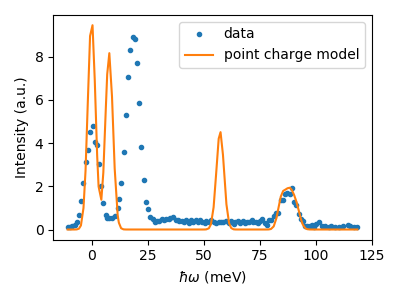

In [3]:
## Import the data
data = np.genfromtxt('Pr2CuO4.dat', unpack=True)

## Calculate the neutron spectrum
CalculatedSpectrum = Pr.neutronSpectrum(data[0], Temp=5, Ei=250, ResFunc = lambda x: 4)


###### Plot result
plt.figure(figsize=(4,3))
plt.plot(data[0], data[1], marker='.', ls='none', label='data')
plt.plot(data[0], CalculatedSpectrum*6, label='point charge model')
# plot labels
plt.legend()
plt.xlabel('$\\hbar \\omega$ (meV)')
plt.ylabel('Intensity (a.u.)')
plt.tight_layout()

# Fit the data

Here I am using the simplest possible way to define error: a $\chi^2$ function based on the difference between calculated and measured intensity. The fit does not converge well, but the point here is to demonstrate bare-bones code.

One could make the fit more sophisticated by including a $\chi^2$ term from the difference between measured and calculated peak energy.

In [4]:
def err_global(CFLevelsObject, coeff, gamma, prefactor):
    """Global error function used for fitting"""
    
    # define new Hamiltonian
    CFLevelsObject.newCoeff(coeff)

    # Compute error in neutron spectrum
    erro = np.sum((prefactor*CFLevelsObject.neutronSpectrum(Earray=data[0], Temp = 5, 
                   Ei = 250, ResFunc=lambda x: 4, gamma=gamma ) - data[1])**2)

    return erro


#************************************************************
# Fit to neutron data

FitCoefRes1 = Pr.fitdata(chisqfunc = err_global,  fitargs = ['coeff','prefactor'], 
            coeff = Pr.B,  gamma=1, prefactor=6)

46.687630711534545
612.2401945216602
Initial err = 612.2401945216602 	Final err = 46.687630711534545


## Print and plot the results:

{'coeff': array([-1.53333857e+00,  2.82494575e-02, -4.31297904e-01,  2.25423356e-04,
       -4.55227591e-03]), 'prefactor': array([6.7066075]), 'Chisq': 46.687630711534545}


<IPython.core.display.Javascript object>


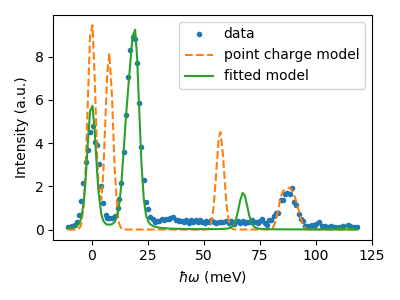

\begin{table*}
\caption{Eigenvectors and Eigenvalues...}
\begin{ruledtabular}
\begin{tabular}{c|ccccccccc}
E (meV) &$|-4\rangle$ & $|-3\rangle$ & $|-2\rangle$ & $|-1\rangle$ & $|0\rangle$ & $|1\rangle$ & $|2\rangle$ & $|3\rangle$ & $|4\rangle$ \tabularnewline
 \hline 
0.000 & 0.0 & -0.8869 & 0.0 & 0.0 & 0.0 & -0.4619 & 0.0 & 0.0 & 0.0 \tabularnewline
0.000 & 0.0 & 0.0 & 0.0 & -0.4619 & 0.0 & 0.0 & 0.0 & -0.8869 & 0.0 \tabularnewline
15.778 & -0.5948 & 0.0 & 0.0 & 0.0 & -0.5408 & 0.0 & 0.0 & 0.0 & -0.5948 \tabularnewline
19.396 & 0.0 & 0.0 & -0.7071 & 0.0 & 0.0 & 0.0 & -0.7071 & 0.0 & 0.0 \tabularnewline
67.619 & -0.7071 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.7071 \tabularnewline
151.720 & 0.0 & 0.0 & 0.7071 & 0.0 & 0.0 & 0.0 & -0.7071 & 0.0 & 0.0 \tabularnewline
161.823 & 0.0 & -0.4619 & 0.0 & 0.0 & 0.0 & 0.8869 & 0.0 & 0.0 & 0.0 \tabularnewline
161.823 & 0.0 & 0.0 & 0.0 & -0.8869 & 0.0 & 0.0 & 0.0 & 0.4619 & 0.0 \tabularnewline
193.023 & 0.3824 & 0.0 & 0.0 & 0.0 & -0.8411 & 0.0

In [6]:
print(FitCoefRes1)

## Build a new Hamiltonian from the fitted arguments

Pr.newCoeff(FitCoefRes1['coeff'])
FittedSpectrum = Pr.neutronSpectrum(data[0], Temp=5, Ei=250, ResFunc = lambda x: 4,
                                   gamma=1,)*FitCoefRes1['prefactor']


###### Plot result
plt.figure(figsize=(4,3))
plt.plot(data[0], data[1], marker='.', ls='none', label='data')
plt.plot(data[0], CalculatedSpectrum*6, label='point charge model', ls='--')
plt.plot(data[0], FittedSpectrum, label='fitted model')
# plot labels
plt.legend()
plt.xlabel('$\\hbar \\omega$ (meV)')
plt.ylabel('Intensity (a.u.)')
plt.tight_layout()


Pr.printLaTexEigenvectors()

## Comments:

- The fit is not well-constrained. There are too few peaks to really fit the Hamiltonian properly. The original paper constrains the fit by including a 91 meV peak observed at elevated temperatures, and assuming that no peaks exist above the measured energies.

- Simplistic fits to CEF levels like this rarely work---this notebook is a skeleton which the user should flesh out with more sophisticatied definitions of $\chi^2$.